# Master Project: Build a Research Agent with LangGraph, GPT-4o, RAG, Pinecone, ArXiv and Google SerpAPI 

## 01 - Extracting Data from ArXiv into a Pandas DataFrame and Saving it as JSON

In [1]:
%%capture
!pip install -r requirements.txt -q

In [2]:
import os
import openai
import getpass

In [3]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OPENAI_API_KEY: ")
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter your LANGCHAIN_API_KEY: ")
os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your TAVILY_API_KEY: ")
os.environ["PINECONE_API_KEY"] = getpass.getpass("Enter your PINECONE_API_KEY: ")


Enter your OPENAI_API_KEY:  ········
Enter your LANGCHAIN_API_KEY:  ········
Enter your TAVILY_API_KEY:  ········
Enter your PINECONE_API_KEY:  ········


In [7]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "pr-research-agent-langgraph"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

In [8]:
import requests
import pandas as pd
import json
import xml.etree.ElementTree as ET

# Namespace for ArXiv's Atom-based XML format.
ARXIV_NAMESPACE = '{http://www.w3.org/2005/Atom}'

def extract_from_arxiv(search_query='cat:cs.AI', max_results=100, json_file_path='files/arxiv_dataset.json'):
    """
    Fetches papers from the ArXiv API based on a search query, saves them as JSON, 
    and returns a pandas DataFrame.

    Args:
        search_query (str): The search query for ArXiv (default is 'cat:cs.AI').
        max_results (int): The maximum number of results to retrieve (default is 100).
        json_file_path (str): File path where JSON data will be saved.

    Returns:
        pd.DataFrame: DataFrame containing the extracted paper information.
    """
    
    # Construct the URL for the API request.
    url = f'http://export.arxiv.org/api/query?search_query={search_query}&max_results={max_results}'
    
    # Send a GET request to the ArXiv API.
    response = requests.get(url)
    
    # Parse the XML response.
    root = ET.fromstring(response.content)
    
    papers = []
    
    # Loop through each "entry" in the XML, representing a single paper.
    for entry in root.findall(f'{ARXIV_NAMESPACE}entry'):
        title = entry.find(f'{ARXIV_NAMESPACE}title').text.strip()
        summary = entry.find(f'{ARXIV_NAMESPACE}summary').text.strip()

        # Get the authors of the paper.
        author_elements = entry.findall(f'{ARXIV_NAMESPACE}author')
        authors = [author.find(f'{ARXIV_NAMESPACE}name').text for author in author_elements]

        # Get the paper's URL.
        paper_url = entry.find(f'{ARXIV_NAMESPACE}id').text
        arxiv_id = paper_url.split('/')[-1]

        # Check for the PDF link.
        pdf_link = next((link.attrib['href'] for link in entry.findall(f'{ARXIV_NAMESPACE}link') 
                         if link.attrib.get('title') == 'pdf'), None)

        papers.append({
            'title': title,
            'summary': summary,
            'authors': authors,
            'arxiv_id': arxiv_id,
            'url': paper_url,
            'pdf_link': pdf_link
        })
    
    # Convert list into a pandas DataFrame.
    df = pd.DataFrame(papers)
    
    # Save the DataFrame to a JSON file.
    with open(json_file_path, 'w', encoding='utf-8') as f:
        json.dump(papers, f, ensure_ascii=False, indent=4)
        print(f'Data saved to {json_file_path} ...')
    
    return df


In [14]:
df = extract_from_arxiv(max_results=50)

Data saved to files/arxiv_dataset.json ...


In [15]:
import json
file_name = 'files/arxiv_dataset.json'
with  open(file_name, 'r') as file:
    data = json.load(file)

# print(data)

In [16]:
import pandas as pd
df = pd.DataFrame(data)
df.sample(n=5)

,title,summary,authors,arxiv_id,url,pdf_link
31,Induction of First-Order Decision Lists: Resul...,This paper presents a method for inducing logi...,"[R. J. Mooney, M. E. Califf]",9506102v1,http://arxiv.org/abs/cs/9506102v1,http://arxiv.org/pdf/cs/9506102v1
42,Decision-Theoretic Foundations for Causal Reas...,We present a definition of cause and effect in...,"[D. Heckerman, R. Shachter]",9512104v1,http://arxiv.org/abs/cs/9512104v1,http://arxiv.org/pdf/cs/9512104v1
11,A Semantics and Complete Algorithm for Subsump...,This paper analyzes the correctness of the sub...,"[A. Borgida, P. F. Patel-Schneider]",9406101v1,http://arxiv.org/abs/cs/9406101v1,http://arxiv.org/pdf/cs/9406101v1
38,Flexibly Instructable Agents,This paper presents an approach to learning fr...,"[S. B. Huffman, J. E. Laird]",9511101v1,http://arxiv.org/abs/cs/9511101v1,http://arxiv.org/pdf/cs/9511101v1
16,On Planning while Learning,This paper introduces a framework for Planning...,"[S. Safra, M. Tennenholtz]",9409101v1,http://arxiv.org/abs/cs/9409101v1,http://arxiv.org/pdf/cs/9409101v1


In [18]:
df.shape

(50, 6)

## 02 - Downloading the Research Papers (PDFs)

In [20]:
import pandas as pd
import requests
import os

def download_pdfs(df, download_folder='files'):
    """
    Downloads PDFs from URLs listed in the DataFrame and saves them to a specified folder. 
    The file names are stored in a new column 'pdf_file_name' in the DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing a 'pdf_link' column with URLs to download.
        download_folder (str): Path to the folder where PDFs will be saved (default is 'files').
    
    Returns:
        pd.DataFrame: The original DataFrame with an additional 'pdf_file_name' column containing 
                      the paths of the downloaded PDF files or None if the download failed.
    """
    
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)
    
    pdf_file_names = []
    
    # Loop through each row to download PDFs
    for index, row in df.iterrows():
        pdf_link = row['pdf_link']
        
        try:
            response = requests.get(pdf_link)
            response.raise_for_status()
    
            file_name = os.path.join(download_folder, pdf_link.split('/')[-1]) + '.pdf'
            pdf_file_names.append(file_name)
    
            # Save the downloaded PDF
            with open(file_name, 'wb') as f:
                f.write(response.content)
            
            print(f'PDF downloaded successfully and saved as {file_name}')
        
        except requests.exceptions.RequestException as e:
            print(f'Failed to download the PDF: {e}')
            pdf_file_names.append(None)
    
    df['pdf_file_name'] = pdf_file_names

    return df

In [21]:
df = download_pdfs(df)

PDF downloaded successfully and saved as files/9308101v1.pdf
PDF downloaded successfully and saved as files/9308102v1.pdf
PDF downloaded successfully and saved as files/9309101v1.pdf
PDF downloaded successfully and saved as files/9311101v1.pdf
PDF downloaded successfully and saved as files/9311102v1.pdf
PDF downloaded successfully and saved as files/9312101v1.pdf
PDF downloaded successfully and saved as files/9401101v1.pdf
PDF downloaded successfully and saved as files/9402101v1.pdf
PDF downloaded successfully and saved as files/9402102v1.pdf
PDF downloaded successfully and saved as files/9402103v1.pdf
PDF downloaded successfully and saved as files/9403101v1.pdf
PDF downloaded successfully and saved as files/9406101v1.pdf
PDF downloaded successfully and saved as files/9406102v1.pdf
PDF downloaded successfully and saved as files/9408101v1.pdf
PDF downloaded successfully and saved as files/9408102v1.pdf
PDF downloaded successfully and saved as files/9408103v1.pdf
PDF downloaded successfu

In [22]:
df.shape

(50, 7)

In [23]:
df.head()

,title,summary,authors,arxiv_id,url,pdf_link,pdf_file_name
0,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,http://arxiv.org/pdf/cs/9308101v1,files/9308101v1.pdf
1,A Market-Oriented Programming Environment and ...,Market price systems constitute a well-underst...,[M. P. Wellman],9308102v1,http://arxiv.org/abs/cs/9308102v1,http://arxiv.org/pdf/cs/9308102v1,files/9308102v1.pdf
2,An Empirical Analysis of Search in GSAT,We describe an extensive study of search in GS...,"[I. P. Gent, T. Walsh]",9309101v1,http://arxiv.org/abs/cs/9309101v1,http://arxiv.org/pdf/cs/9309101v1,files/9309101v1.pdf
3,The Difficulties of Learning Logic Programs wi...,As real logic programmers normally use cut (!)...,"[F. Bergadano, D. Gunetti, U. Trinchero]",9311101v1,http://arxiv.org/abs/cs/9311101v1,http://arxiv.org/pdf/cs/9311101v1,files/9311101v1.pdf
4,Software Agents: Completing Patterns and Const...,To support the goal of allowing users to recor...,"[J. C. Schlimmer, L. A. Hermens]",9311102v1,http://arxiv.org/abs/cs/9311102v1,http://arxiv.org/pdf/cs/9311102v1,files/9311102v1.pdf


## 03 - Loading and Splitting PDF Files into Chunks, Expanding the DataFrame

In [24]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

def load_and_chunk_pdf(pdf_file_name, chunk_size=512):
    """
    Loads a PDF file and splits its content into chunks of a specified size.

    Args:
        file (str): Path to the PDF file to be loaded.
        chunk_size (int): The maximum size of each chunk in characters (default is 512).

    Returns:
        List[Document]: A list of document chunks.
    """

    print(f'Loading and splitting into chunks: {pdf_file_name}')

    # Load the content of the PDF
    loader = PyPDFLoader(pdf_file_name)
    data = loader.load()

    # Split the content into chunks with slight overlap to preserve context
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=64)
    chunks = text_splitter.split_documents(data)

    return chunks

In [25]:
def expand_df(df):
    """
    Expands each row in the DataFrame by splitting PDF documents into chunks.

    Args:
        df (pd.DataFrame): DataFrame containing 'pdf_file_name', 'arxiv_id', 'title', 'summary', 
                           'authors', and 'url' columns.

    Returns:
        pd.DataFrame: A new DataFrame where each row represents a chunk of the original document, 
                      with additional metadata such as chunk identifiers and relationships to 
                      adjacent chunks.
    """

    expanded_rows = []  # List to store expanded rows with chunk information

    # Loop through each row in the DataFrame
    for idx, row in df.iterrows():
        try:
            chunks = load_and_chunk_pdf(row['pdf_file_name'])
        except Exception as e:
            print(f"Error processing file {row['pdf_file_name']}: {e}")
            continue

        # Loop over the chunks and construct a new DataFrame row for each
        for i, chunk in enumerate(chunks):
            prechunk_id = i-1 if i > 0 else ''  # Preceding chunk ID
            postchunk_id = i+1 if i < len(chunks) - 1 else ''  # Following chunk ID

            expanded_rows.append({
                'id': f"{row['arxiv_id']}#{i}",  # Unique chunk identifier
                'title': row['title'],
                'summary': row['summary'],
                'authors': row['authors'],
                'arxiv_id': row['arxiv_id'],
                'url': row['url'],
                'chunk': chunk.page_content,  # Text content of the chunk
                'prechunk_id': '' if i == 0 else f"{row['arxiv_id']}#{prechunk_id}",  # Previous chunk ID
                'postchunk_id': '' if i == len(chunks) - 1 else f"{row['arxiv_id']}#{postchunk_id}"  # Next chunk ID
            })

    # Return a new expanded DataFrame
    return pd.DataFrame(expanded_rows)

In [26]:
expanded_df = expand_df(df)

Loading and splitting into chunks: files/9308101v1.pdf
Loading and splitting into chunks: files/9308102v1.pdf
Loading and splitting into chunks: files/9309101v1.pdf
Loading and splitting into chunks: files/9311101v1.pdf
Loading and splitting into chunks: files/9311102v1.pdf
Loading and splitting into chunks: files/9312101v1.pdf
Loading and splitting into chunks: files/9401101v1.pdf
Loading and splitting into chunks: files/9402101v1.pdf
Loading and splitting into chunks: files/9402102v1.pdf
Loading and splitting into chunks: files/9402103v1.pdf
Loading and splitting into chunks: files/9403101v1.pdf
Loading and splitting into chunks: files/9406101v1.pdf
Loading and splitting into chunks: files/9406102v1.pdf
Loading and splitting into chunks: files/9408101v1.pdf
Loading and splitting into chunks: files/9408102v1.pdf
Loading and splitting into chunks: files/9408103v1.pdf
Loading and splitting into chunks: files/9409101v1.pdf
Loading and splitting into chunks: files/9412101v1.pdf
Loading an

In [27]:
expanded_df.shape

(12370, 9)

In [28]:
expanded_df.head()

,id,title,summary,authors,arxiv_id,url,chunk,prechunk_id,postchunk_id
0,9308101v1#0,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,Journal of Arti/ cial In telligence Researc h ...,,9308101v1#1
1,9308101v1#1,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,"problem/. In this pap er/, w e presen t a meth...",9308101v1#0,9308101v1#2
2,9308101v1#2,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,b y earlier approac hes/.\n/1/. In tro duction...,9308101v1#1,9308101v1#3
3,9308101v1#3,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,remaining problem in t w o/. W e no w b egin t...,9308101v1#2,9308101v1#4
4,9308101v1#4,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,there is no p oin t in w asting time completin...,9308101v1#3,9308101v1#5


## 04 - Building a Knowledge Base for the RAG System Using Embedding

In [29]:
from semantic_router.encoders import OpenAIEncoder

# Check if 'OPENAI_API_KEY' is set; prompt if not
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY') or getpass('OpenAI API key: ')

# Initialize the OpenAIEncoder with a specific model
encoder = OpenAIEncoder(name='text-embedding-3-small')

In [31]:
# encoder('hello hallo hola salut')

In [32]:
dims = len(encoder('hello hallo hola salut')[0])
dims

1536

## 05 - Creating a Pinecone Index

In [33]:
from pinecone import Pinecone, ServerlessSpec

# Check if 'PINECONE_API_KEY' is set; prompt if not
api_key = os.getenv('PINECONE_API_KEY') or getpass('Pinecone API key: ')

# Initialize the Pinecone client
pc = Pinecone(api_key=api_key)

# Define the serverless specification for Pinecone (AWS region 'us-east-1')
spec = ServerlessSpec(
    cloud='aws', 
    region='us-east-1'
)

In [34]:
import time

# Define the name of the index
index_name = 'langgraph-research-agent'

# Check if the index exists; create it if it doesn't
if index_name not in pc.list_indexes().names():
    pc.create_index(
        index_name,
        dimension=dims,  # Embedding dimension (1536)
        metric='cosine',
        spec=spec  # Cloud provider and region specification
    )

    # Wait until the index is fully initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# Connect to the index
index = pc.Index(index_name)

# Add a short delay before checking the stats
time.sleep(1)

# View the index statistics
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

## 06 - Populating the Knowledge Base and Uploading it to Pinecone

In [35]:
expanded_df.iloc[:5]

,id,title,summary,authors,arxiv_id,url,chunk,prechunk_id,postchunk_id
0,9308101v1#0,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,Journal of Arti/ cial In telligence Researc h ...,,9308101v1#1
1,9308101v1#1,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,"problem/. In this pap er/, w e presen t a meth...",9308101v1#0,9308101v1#2
2,9308101v1#2,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,b y earlier approac hes/.\n/1/. In tro duction...,9308101v1#1,9308101v1#3
3,9308101v1#3,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,remaining problem in t w o/. W e no w b egin t...,9308101v1#2,9308101v1#4
4,9308101v1#4,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,there is no p oin t in w asting time completin...,9308101v1#3,9308101v1#5


In [36]:
from tqdm.auto import tqdm

data = expanded_df
batch_size = 64  # Set batch size

# Loop through the data in batches, using tqdm for a progress bar
for i in tqdm(range(0, len(data), batch_size)):
    i_end = min(len(data), i + batch_size)  # Define batch endpoint
    batch = data[i:i_end].to_dict(orient='records')  # Slice data into a batch

    # Extract metadata for each chunk in the batch
    metadata = [{
        'arxiv_id': r['arxiv_id'],
        'title': r['title'],
        'chunk': r['chunk'],
    } for r in batch]
    
    # Generate unique IDs for each chunk
    ids = [r['id'] for r in batch]
    
    # Extract the chunk content
    chunks = [r['chunk'] for r in batch]
    
    # Convert chunks into embeddings
    embeds = encoder(chunks)
    
    # Upload embeddings, IDs, and metadata to Pinecone
    index.upsert(vectors=zip(ids, embeds, metadata))


  0%|          | 0/194 [00:00<?, ?it/s]

In [38]:
# Display the index statistics.
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 12370}},
 'total_vector_count': 12370}

## 07 - Implementing the ArXiv Fetch Tool

In [39]:
import requests
# Specify the arXiv ID for the paper
arxiv_id = '1706.03762'

# Make a GET request to retrieve the page for the specified paper
res = requests.get(f'https://arxiv.org/abs/{arxiv_id}')

# Access the content of the response as a string (HTML)
res.text

'<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml" lang="en" xml:lang="en">\n\n<head>  <title>[1706.03762] Attention Is All You Need</title>\n  <meta name="viewport" content="width=device-width, initial-scale=1">\n  <link rel="apple-touch-icon" sizes="180x180" href="/static/browse/0.3.4/images/icons/apple-touch-icon.png">\n  <link rel="icon" type="image/png" sizes="32x32" href="/static/browse/0.3.4/images/icons/favicon-32x32.png">\n  <link rel="icon" type="image/png" sizes="16x16" href="/static/browse/0.3.4/images/icons/favicon-16x16.png">\n  <link rel="manifest" href="/static/browse/0.3.4/images/icons/site.webmanifest">\n  <link rel="mask-icon" href="/static/browse/0.3.4/images/icons/safari-pinned-tab.svg" color="#5bbad5">\n  <meta name="msapplication-TileColor" content="#da532c">\n  <meta name="theme-color" content="#ffffff">\n  <

In [40]:
import re

# Compile a regular expression pattern to find the abstract in the HTML response
abstract_pattern = re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL
)

# Search for the abstract in the HTML response text
re_match = abstract_pattern.search(res.text)

# Check if the abstract was found and print it; otherwise, display an error message
if re_match:
    print(re_match.group(1))
else:
    print('Abstract not found.')

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transforme

In [41]:
from langchain_core.tools import tool
import requests
import re

# Compile a regular expression pattern to find the abstract in the HTML response
abstract_pattern = re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL
)

@tool('fetch_arxiv')
def fetch_arxiv(arxiv_id: str) -> str:
    '''Fetches the abstract from an ArXiv paper given its ArXiv ID.

    Args:
        arxiv_id (str): The ArXiv paper ID.
    
    Returns:
        str: The extracted abstract text from the ArXiv paper.
    '''

    res = requests.get(f'https://arxiv.org/abs/{arxiv_id}')
    
    re_match = abstract_pattern.search(res.text)

    return re_match.group(1) if re_match else 'Abstract not found.'

In [42]:
# Defining the ArXiv paper ID and invoking the tool with that ID.
arxiv_id = '1706.03762'
output = fetch_arxiv.invoke(input={'arxiv_id': arxiv_id})
print(output)

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transforme

## 08 - Implementing the Web Search Tools with Google SerpAPI

In [43]:
from serpapi import GoogleSearch
from getpass import getpass

# Set up the SerpAPI request parameters, including the API key.
serpapi_params = {
    'engine': 'google',  
    'api_key': os.getenv('SERPAPI_KEY') or getpass('SerpAPI key: ')  # Get the API key securely.
}

# Perform a Google search for the keyword "water" and limit the results to 5.
search = GoogleSearch({
    **serpapi_params,
    'q': 'water',
    'num': 5
})


# Extract the main search results from the API response.
results = search.get_dict().get('organic_results', [])

# Format the search results for readability.
formatted_results = '\n---\n'.join(
    ['\n'.join([x['title'], x['snippet'], x['link']]) for x in results]
)

SerpAPI key:  ········


In [44]:
print(formatted_results)

Water
Water is an inorganic compound with the chemical formula H 2O. It is a transparent, tasteless, odorless, and nearly colorless chemical substance.
https://en.wikipedia.org/wiki/Water
---
Waters Corporation | Laboratory Instruments ...
Waters is the leading provider of lab equipment, supplies and software for scientists across the world. Easily research and order everything your lab needs!
https://www.waters.com/nextgen/us/en.html?srsltid=AfmBOopY715XtsW-xqsy1_FnfbwgWClvdSaEcWHZ7nH9PzX-01hnnT08
---
Water | Definition, Chemical Formula, Structure, Molecule ...
Water, substance composed of the chemical elements hydrogen and oxygen and existing in gaseous, liquid, and solid states. It is one of the ...
https://www.britannica.com/science/water
---
Water For People: Clean Water Around the World
Water For People is helping millions of people across nine countries get access to clean water. You can make a difference!
https://www.waterforpeople.org/


In [45]:
from serpapi import GoogleSearch

# Define the 'web_search' tool using the '@tool' decorator.
@tool('web_search')
def web_search(query: str) -> str:
    '''Finds general knowledge information using a Google search.

    Args:
        query (str): The search query string.
    
    Returns:
        str: A formatted string of the top search results, including title, snippet, and link.
    '''

    search = GoogleSearch({
        **serpapi_params,  
        'q': query,        
        'num': 5         
    })
   
    results = search.get_dict().get('organic_results', [])
    formatted_results = '\n---\n'.join(
        ['\n'.join([x['title'], x['snippet'], x['link']]) for x in results]
    )
    
    # Return the formatted results or a 'No results found.' message if no results exist.
    return formatted_results if results else 'No results found.'

In [46]:
# Invoke the 'web_search' tool with the query 'water on mars'
output = web_search.invoke(input={'query': 'water on mars'})
print(output)

Water on Mars
Mars contains water, though mostly as permafrost. As top surface layer water appears readily visible at some places, such as the polar Korolev Crater.
https://en.wikipedia.org/wiki/Water_on_Mars
---
NASA Confirms Evidence That Liquid Water Flows ...
New findings from NASA's Mars Reconnaissance Orbiter (MRO) provide the strongest evidence yet that liquid water flows intermittently on present-day Mars.
https://www.nasa.gov/news-release/nasa-confirms-evidence-that-liquid-water-flows-on-todays-mars/
---
Scientists find oceans of water on Mars. It's just too deep to ...
A new analysis of Mars' interior suggests that much of the liquid water still exists in the pores of rocks 10-20 kilometers below the surface.
https://news.berkeley.edu/2024/08/12/scientists-find-oceans-of-water-on-mars-its-just-too-deep-to-tap/


In [47]:
output = web_search.invoke(input={'query': 'llms'})
print(output)

Large language model
A large language model (LLM) is a type of computational model designed for natural language processing tasks such as language generation.
https://en.wikipedia.org/wiki/Large_language_model
---
What is LLM? - Large Language Models Explained
Large language models, also known as LLMs, are very large deep learning models that are pre-trained on vast amounts of data. The underlying transformer is a ...
https://aws.amazon.com/what-is/large-language-model/
---
What Are Large Language Models (LLMs)?
Large language models are AI systems capable of understanding and generating human language by processing vast amounts of text data.
https://www.ibm.com/topics/large-language-models


## 09 - Creating RAG Tools for Retrieval-Augmented Generation (RAG)

In [49]:
def format_rag_contexts(matches: list) -> str:
    '''Formats the retrieved context matches into a readable string format.

    Args:
        matches (list): A list of matched documents with metadata.
    
    Returns:
        str: A formatted string of document titles, chunks, and ArXiv IDs.
    '''
    formatted_results = []
    
    # Loop through each match and extract its metadata.
    for x in matches:
        text = (
            f"Title: {x['metadata']['title']}\n"
            f"Chunk: {x['metadata']['chunk']}\n"
            f"ArXiv ID: {x['metadata']['arxiv_id']}\n"
        )
        # Append each formatted string to the results list.
        formatted_results.append(text)
    
    # Join all the individual formatted strings into one large string.
    return '\n---\n'.join(formatted_results)

In [50]:
from langchain_core.tools import tool

@tool
def rag_search_filter(query: str, arxiv_id: str) -> str:
    '''Finds information from the ArXiv database using a natural language query and a specific ArXiv ID.

    Args:
        query (str): The search query in natural language.
        arxiv_id (str): The ArXiv ID of the specific paper to filter by.
    
    Returns:
        str: A formatted string of relevant document contexts.
    '''
    
    # Encode the query into a vector representation.
    xq = encoder([query])
    
    # Perform a search on the Pinecone index, filtering by ArXiv ID.
    xc = index.query(vector=xq, top_k=6, include_metadata=True, filter={'arxiv_id': arxiv_id})
    
    # Format and return the search results.
    return format_rag_contexts(xc['matches'])

In [51]:
@tool('rag_search')
def rag_search(query: str) -> str:
    '''Finds specialist information on AI using a natural language query.

    Args:
        query (str): The search query in natural language.
    
    Returns:
        str: A formatted string of relevant document contexts.
    '''
    
    # Encode the query into a vector representation.
    xq = encoder([query])
    
    # Perform a broader search without filtering by ArXiv ID.
    xc = index.query(vector=xq, top_k=5, include_metadata=True)
    
    # Format and return the search results.
    return format_rag_contexts(xc['matches'])

## 10 - Implementing the Final Answer Generation Tool

In [52]:
from langchain_core.tools import tool

# Define the 'final_answer' tool to compile the research report.
@tool
def final_answer(
    introduction: str,
    research_steps: str or list,
    main_body: str,
    conclusion: str,
    sources: str or list
) -> str:
    '''Returns a natural language response in the form of a research report.

    Args:
        introduction (str): A short paragraph introducing the user's question and the topic.
        research_steps (str or list): Bullet points or text explaining the steps taken for research.
        main_body (str): The bulk of the answer, 3-4 paragraphs long, providing high-quality information.
        conclusion (str): A short paragraph summarizing the findings.
        sources (str or list): A list or text providing the sources referenced during the research.

    Returns:
        str: A formatted research report string.
    '''

    # Format research steps if given as a list.
    if isinstance(research_steps, list):
        research_steps = '\n'.join([f'- {r}' for r in research_steps])
    
    # Format sources if given as a list.
    if isinstance(sources, list):
        sources = '\n'.join([f'- {s}' for s in sources])
    
    # Construct and return the final research report.
    return f'{introduction}\n\nResearch Steps:\n{research_steps}\n\nMain Body:\n{main_body}\n\n \
    Conclusion:\n{conclusion}\n\nSources:\n{sources}'


## 11 - Initializing the "Oracle" LLM

In [53]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# Define the system prompt guiding the AI's decision-making process.
system_prompt = (
    '''You are the oracle, the great AI decision-maker.
    Given the user's query, you must decide what to do with it based on the
    list of tools provided to you.

    If you see that a tool has been used (in the scratchpad) with a particular
    query, do NOT use that same tool with the same query again. Also, do NOT use
    any tool more than twice (i.e., if the tool appears in the scratchpad twice, do
    not use it again).

    You should aim to collect information from a diverse range of sources before
    providing the answer to the user. Once you have collected plenty of information
    to answer the user's question (stored in the scratchpad), use the final_answer tool.'''
)


# Create a prompt template for the conversation flow.
prompt = ChatPromptTemplate.from_messages([
    ('system', system_prompt),  # Define the AI's role and rules.
    
    # Insert past chat messages to maintain context.
    MessagesPlaceholder(variable_name='chat_history'),
    
    # Insert user's input dynamically.
    ('user', '{input}'),
    
    # Include the assistant's scratchpad to track tool usage and intermediate steps.
    ('assistant', 'scratchpad: {scratchpad}'),
])

In [54]:
from langchain_core.messages import ToolCall, ToolMessage
from langchain_openai import ChatOpenAI
import os

# Initialize the OpenAI language model with specific settings.
llm = ChatOpenAI(
    model='gpt-4o',
    openai_api_key=os.environ['OPENAI_API_KEY'],
    temperature=0
)

# Define the list of tools available to the oracle.
tools = [
    rag_search_filter,
    rag_search,
    fetch_arxiv,
    web_search,
    final_answer
]

# Function to create the scratchpad from the intermediate tool calls.
def create_scratchpad(intermediate_steps: list[ToolCall]) -> str:
    research_steps = []
    
    # Loop over each step and process tool calls with actual outputs.
    for i, action in enumerate(intermediate_steps):
        if action.log != 'TBD':
            research_steps.append(
                f'Tool: {action.tool}, input: {action.tool_input}\n'
                f'Output: {action.log}'
            )
    
    # Join the research steps into a readable log.
    return '\n---\n'.join(research_steps)

# Define the oracle's decision-making pipeline.
oracle = (
    {
        'input': lambda x: x['input'],
        'chat_history': lambda x: x['chat_history'],
        'scratchpad': lambda x: create_scratchpad(intermediate_steps=x['intermediate_steps']),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice='any')
)

## 12 -  Testing the Oracle and the Tools

In [59]:
# input = 'Tell me something interesting about dynamic backtracking AI and LLMs'
# input = 'Who won the Super Bowl 2024?'
input = 'What is the ArXiv paper with the ID 2407.21783 all about?'
# Create the inputs dictionary, containing the user's query and initial empty chat history and intermediate steps.
inputs = {
    'input': input,
    'chat_history': [],
    'intermediate_steps': [],
}

# Invoke the oracle with the inputs, processing the query and returning a response.
out = oracle.invoke(inputs)

# Display the oracle's response.
print(out)

content='' additional_kwargs={'tool_calls': [{'id': 'call_Ahyg8ycfUkl3YdG4a8F2zWEp', 'function': {'arguments': '{"arxiv_id":"2407.21783"}', 'name': 'fetch_arxiv'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 604, 'total_tokens': 625, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_9d50cd990b', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-6e0663dc-53f5-4670-8550-47bcda989233-0' tool_calls=[{'name': 'fetch_arxiv', 'args': {'arxiv_id': '2407.21783'}, 'id': 'call_Ahyg8ycfUkl3YdG4a8F2zWEp', 'type': 'tool_call'}] usage_metadata={'input_tokens': 604, 'output_tokens': 21, 'total_tokens': 625, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0

In [60]:
out.tool_calls

[{'name': 'fetch_arxiv',
  'args': {'arxiv_id': '2407.21783'},
  'id': 'call_Ahyg8ycfUkl3YdG4a8F2zWEp',
  'type': 'tool_call'}]

In [61]:
# Display the name of the tool
out.tool_calls[0]['name']

'fetch_arxiv'

In [62]:
# Display the tool's arguments
out.tool_calls[0]['args']

{'arxiv_id': '2407.21783'}

## 12 - Building a Decision-Making Pipeline

In [63]:
# run_oracle(): main function that executes the oracle and processes its output to extract the relevant tool and its arguments.
# We'll use this information to update the state for future steps.
def run_oracle(state: dict) -> dict:
    '''Runs the oracle and processes the output to extract tool information.

    Args:
        state (dict): The current state containing the 'intermediate_steps'.

    Returns:
        dict: A new state with updated 'intermediate_steps' including the tool action.
    '''
    
    print('run_oracle')
    print(f'intermediate_steps: {state["intermediate_steps"]}')
    
    # Invoke the oracle with the current state.
    out = oracle.invoke(state)

    # Extract the tool name and its arguments from the oracle's response.
    tool_name = out.tool_calls[0]['name']
    tool_args = out.tool_calls[0]['args']

    # Create an AgentAction object, which records the tool used and the input provided.
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log='TBD'  # To be determined later after the tool runs.
    )

    # Return a new state with updated 'intermediate_steps'.
    return {
        'intermediate_steps': [action_out]
    }


# The router() function determines the next tool to use based on the current state.
def router(state: dict) -> str:
    '''Determines the next tool to use based on the current state.

    Args:
        state (dict): The current state containing 'intermediate_steps'.

    Returns:
        str: The name of the tool to use next.
    '''

    if isinstance(state['intermediate_steps'], list):
        return state['intermediate_steps'][-1].tool
    else:
        print('Router invalid format')
        return 'final_answer'


tool_str_to_func = {
    'rag_search_filter': rag_search_filter,
    'rag_search': rag_search,
    'fetch_arxiv': fetch_arxiv,
    'web_search': web_search,
    'final_answer': final_answer
}

# The run_tool() function executes the appropriate tool based on the current state.
def run_tool(state: dict) -> dict:
    '''Executes the appropriate tool based on the current state.

    Args:
        state (dict): The current state containing the 'intermediate_steps'.

    Returns:
        dict: A new state with updated 'intermediate_steps' including the tool's result.
    '''

    tool_name = state['intermediate_steps'][-1].tool
    tool_args = state['intermediate_steps'][-1].tool_input

    print(f'{tool_name}.invoke(input={tool_args})')

    out = tool_str_to_func[tool_name].invoke(input=tool_args)

    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )

    return {'intermediate_steps': [action_out]}

## 13 - Defining the Agent State

In [64]:
from typing import TypedDict, Annotated, List
from langchain_core.agents import AgentAction
from langchain_core.messages import BaseMessage
import operator

class AgentState(TypedDict):
    '''Represents the state of an agent.'''
    
    input: str
    chat_history: List[BaseMessage]
    intermediate_steps: Annotated[List[tuple[AgentAction, str]], operator.add]

## 14 - Defining the Graph for Decision-Making

In [65]:
from langgraph.graph import StateGraph, END

# Initialize the state graph with AgentState to manage the workflow.
graph = StateGraph(AgentState)

graph.add_node('oracle', run_oracle)
graph.add_node('rag_search_filter', run_tool)
graph.add_node('rag_search', run_tool)
graph.add_node('fetch_arxiv', run_tool)
graph.add_node('web_search', run_tool)
graph.add_node('final_answer', run_tool)

# Set the entry point to 'oracle'.
graph.set_entry_point('oracle')

# Add conditional edges to determine the next step using the router function.
graph.add_conditional_edges(source='oracle', path=router)

# Add edges from each tool back to 'oracle', except 'final_answer', which leads to 'END'.
for tool_obj in tools:
    if tool_obj.name != 'final_answer':
        graph.add_edge(tool_obj.name, 'oracle')

graph.add_edge('final_answer', END)

# Compile the graph to make it executable.
runnable = graph.compile()

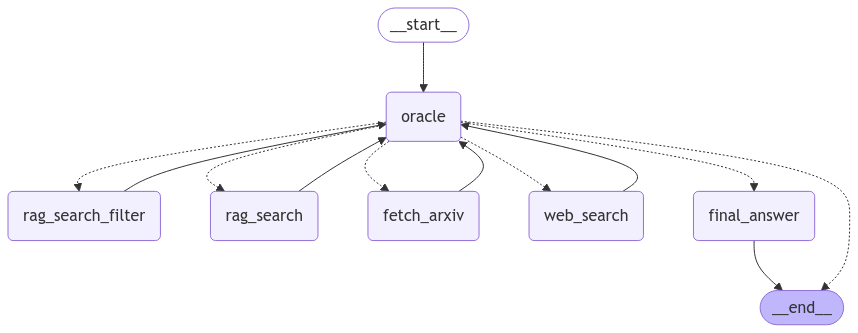

In [66]:
from IPython.display import Image, display

# Display the graph as a PNG using Mermaid rendering.
display(Image(runnable.get_graph().draw_mermaid_png()))

In [67]:
# Run the graph with input.
output = runnable.invoke({
    'input': 'Tell me something interesting about Dynamic Backtracking AI and LLMs',
    'chat_history': [],
})

run_oracle
intermediate_steps: []
rag_search.invoke(input={'query': 'Dynamic Backtracking AI'})
run_oracle
intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'Dynamic Backtracking AI'}, log='TBD'), AgentAction(tool='rag_search', tool_input={'query': 'Dynamic Backtracking AI'}, log='Title: Dynamic Backtracking\nChunk: Journal of Arti/\x0ccial In telligence Researc h /1 /(/1/9/9/3/) /2/5/-/4/6 Submitted /7///9/3/; published /8///9/3\nDynamic Bac ktrac king\nMatthew L/. Ginsb erg ginsber g/@cs/.uoregon/.edu\nCIRL/, University of Or e gon/,\nEugene/, OR /9/7/4/0/3/-/1/2/6/9 USA\nAbstract\nBecause of their o ccasional need to return to shallo w p oin ts in a searc h tree/, existing\nbac ktrac king metho ds can sometimes erase meaningful progress to w ard solving a searc h\nArXiv ID: 9308101v1\n\n---\nTitle: Dynamic Backtracking\nChunk: D ynamic Ba cktra cking\nPro of/. That few er no des are examined is clear/; for completeness/, it follo ws from Lemma\n/3/./2 that the

In [70]:
output.keys()

dict_keys(['input', 'chat_history', 'intermediate_steps'])

## 15 - Generating Reports: Building a Formatted Final Report

In [71]:
def build_report(output: dict) -> str:
    '''Builds a formatted report based on the oracle's output.

    Args:
        output (dict): A dictionary containing the various sections of the report (graph's output).

    Returns:
        str: A formatted string containing the full research report.
    '''
    research_steps = output['research_steps']
    if isinstance(research_steps, list):
        research_steps = '\n'.join([f'- {r}' for r in research_steps])
    
    sources = output['sources']
    if isinstance(sources, list):
        sources = '\n'.join([f'- {s}' for s in sources])
    
    return f"""
        INTRODUCTION
        ------------
        {output['introduction']}
        
        RESEARCH STEPS
        --------------
        {research_steps}
        
        REPORT
        ------
        {output['main_body']}
        
        CONCLUSION
        ----------
        {output['conclusion']}
        
        SOURCES
        -------
        {sources}
    """


In [72]:
# Run the graph with input.
output = runnable.invoke({
    'input': 'Tell me something interesting about Dynamic Backtracking AI and LLMs',
    'chat_history': [],
})

run_oracle
intermediate_steps: []
rag_search.invoke(input={'query': 'Dynamic Backtracking AI'})
run_oracle
intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'Dynamic Backtracking AI'}, log='TBD'), AgentAction(tool='rag_search', tool_input={'query': 'Dynamic Backtracking AI'}, log='Title: Dynamic Backtracking\nChunk: Journal of Arti/\x0ccial In telligence Researc h /1 /(/1/9/9/3/) /2/5/-/4/6 Submitted /7///9/3/; published /8///9/3\nDynamic Bac ktrac king\nMatthew L/. Ginsb erg ginsber g/@cs/.uoregon/.edu\nCIRL/, University of Or e gon/,\nEugene/, OR /9/7/4/0/3/-/1/2/6/9 USA\nAbstract\nBecause of their o ccasional need to return to shallo w p oin ts in a searc h tree/, existing\nbac ktrac king metho ds can sometimes erase meaningful progress to w ard solving a searc h\nArXiv ID: 9308101v1\n\n---\nTitle: Dynamic Backtracking\nChunk: D ynamic Ba cktra cking\nPro of/. That few er no des are examined is clear/; for completeness/, it follo ws from Lemma\n/3/./2 that the

In [73]:
output['intermediate_steps'][-1].tool_input 

{'introduction': 'Dynamic Backtracking and Large Language Models (LLMs) are two fascinating areas in the field of artificial intelligence. Dynamic Backtracking is a method used to enhance the efficiency of search algorithms, while LLMs are advanced AI models designed for natural language processing tasks.',
 'research_steps': '1. Conducted a specialized search on Dynamic Backtracking AI using the RAG search tool.\n2. Conducted a specialized search on LLMs using the RAG search tool.\n3. Performed a web search for additional information on Dynamic Backtracking AI.\n4. Performed a web search for additional information on LLMs.',
 'main_body': 'Dynamic Backtracking is a variant of dependency-directed backtracking that optimizes the search process by moving backtrack points deeper into the search space. This technique is particularly useful in constraint satisfaction problems (CSPs) where it helps in reducing the number of nodes examined, thus saving computational resources. The method has 

In [74]:
output['intermediate_steps'][-1].tool_input.keys()

dict_keys(['introduction', 'research_steps', 'main_body', 'conclusion', 'sources'])

In [75]:
report = build_report(
    output=output['intermediate_steps'][-1].tool_input
)

print(report)


        INTRODUCTION
        ------------
        Dynamic Backtracking and Large Language Models (LLMs) are two fascinating areas in the field of artificial intelligence. Dynamic Backtracking is a method used to enhance the efficiency of search algorithms, while LLMs are advanced AI models designed for natural language processing tasks.
        
        RESEARCH STEPS
        --------------
        1. Conducted a specialized search on Dynamic Backtracking AI using the RAG search tool.
2. Conducted a specialized search on LLMs using the RAG search tool.
3. Performed a web search for additional information on Dynamic Backtracking AI.
4. Performed a web search for additional information on LLMs.
        
        REPORT
        ------
        Dynamic Backtracking is a variant of dependency-directed backtracking that optimizes the search process by moving backtrack points deeper into the search space. This technique is particularly useful in constraint satisfaction problems (CSPs) where it

In [76]:
from IPython.display import Markdown, display

display(Markdown(report))


        INTRODUCTION
        ------------
        Dynamic Backtracking and Large Language Models (LLMs) are two fascinating areas in the field of artificial intelligence. Dynamic Backtracking is a method used to enhance the efficiency of search algorithms, while LLMs are advanced AI models designed for natural language processing tasks.
        
        RESEARCH STEPS
        --------------
        1. Conducted a specialized search on Dynamic Backtracking AI using the RAG search tool.
2. Conducted a specialized search on LLMs using the RAG search tool.
3. Performed a web search for additional information on Dynamic Backtracking AI.
4. Performed a web search for additional information on LLMs.
        
        REPORT
        ------
        Dynamic Backtracking is a variant of dependency-directed backtracking that optimizes the search process by moving backtrack points deeper into the search space. This technique is particularly useful in constraint satisfaction problems (CSPs) where it helps in reducing the number of nodes examined, thus saving computational resources. The method has been applied in various AI subfields, including planning and vision, and has been incorporated into applications like crossword-puzzle generation, demonstrating significant performance improvements.

On the other hand, Large Language Models (LLMs) are a type of deep learning model designed for natural language processing tasks. These models, such as GPT-3, are pre-trained on vast amounts of text data and are capable of understanding and generating human-like text. LLMs utilize transformer architectures, which allow them to process and generate language with remarkable fluency and coherence. They have a wide range of applications, from chatbots and virtual assistants to content creation and translation services. However, their large size and complexity also pose challenges, including high computational costs and potential biases in generated content.
        
        CONCLUSION
        ----------
        Dynamic Backtracking and LLMs represent significant advancements in AI, each addressing different challenges within the field. While Dynamic Backtracking enhances search efficiency in CSPs, LLMs push the boundaries of what is possible in natural language processing. Both technologies continue to evolve, offering exciting possibilities for future AI applications.
        
        SOURCES
        -------
        - Journal of Artificial Intelligence Research
- ArXiv papers on Dynamic Backtracking
- Wikipedia and IBM articles on Large Language Models
- AWS and Cloudflare resources on LLMs
    

In [77]:
output = runnable.invoke({
    'input': 'tell me about FIFA World Cup 26',
    'chat_history': []  
})

run_oracle
intermediate_steps: []
web_search.invoke(input={'query': 'FIFA World Cup 2026 overview'})
run_oracle
intermediate_steps: [AgentAction(tool='web_search', tool_input={'query': 'FIFA World Cup 2026 overview'}, log='TBD'), AgentAction(tool='web_search', tool_input={'query': 'FIFA World Cup 2026 overview'}, log='FIFA World Cup 26™\nThe FIFA World Cup 26™ will be the 23rd edition of the tournament but the first to feature 48 teams and three host countries: Canada, Mexico and the United ...\nhttps://www.fifa.com/en/tournaments/mens/worldcup/canadamexicousa2026\n---\n2026 FIFA World Cup\nThe tournament will take place from June 11 to July 19, 2026. It will be jointly hosted by 16 cities in three North American countries: Canada, Mexico, and the ...\nhttps://en.wikipedia.org/wiki/2026_FIFA_World_Cup')]
rag_search.invoke(input={'query': 'FIFA World Cup 2026 details'})
run_oracle
intermediate_steps: [AgentAction(tool='web_search', tool_input={'query': 'FIFA World Cup 2026 overview'}, l

In [78]:
report = build_report(
    output=output['intermediate_steps'][-1].tool_input
)

# print(report)
display(Markdown(report))


        INTRODUCTION
        ------------
        The FIFA World Cup 2026 is set to be a landmark event in the history of international football, marking the first time the tournament will feature 48 teams and be hosted across three countries.
        
        RESEARCH STEPS
        --------------
        1. Conducted a web search to gather general information about the FIFA World Cup 2026.
2. Utilized a specialized AI search to find detailed insights about the event.
        
        REPORT
        ------
        The FIFA World Cup 2026 will be the 23rd edition of the tournament and is scheduled to take place from June 11 to July 19, 2026. This edition is particularly significant as it will be the first to expand the number of participating teams from 32 to 48, allowing for a broader representation of countries from around the world. The tournament will be jointly hosted by three North American countries: Canada, Mexico, and the United States. This marks the first time the World Cup will be hosted by three nations, and the first time since 1994 that the United States will host the event. Mexico will be hosting the World Cup for the third time, having previously hosted in 1970 and 1986, while Canada will be hosting for the first time.

The decision to expand the tournament to 48 teams was made to increase global participation and interest in the sport. The format will include a total of 80 matches, with the final match scheduled to be held in the United States. The host cities will include major metropolitan areas across the three countries, providing a diverse cultural experience for fans and players alike.

The expansion and the tri-nation hosting are expected to bring significant economic benefits to the host countries, with increased tourism and global attention. The event is also seen as an opportunity to promote unity and collaboration among the host nations, showcasing their ability to work together on a global stage.
        
        CONCLUSION
        ----------
        The FIFA World Cup 2026 promises to be a groundbreaking event, with its expanded format and unique hosting arrangement. It is set to offer an exciting and inclusive experience for football fans worldwide, while also fostering international cooperation and cultural exchange.
        
        SOURCES
        -------
        1. FIFA official website: https://www.fifa.com/en/tournaments/mens/worldcup/canadamexicousa2026
2. Wikipedia: https://en.wikipedia.org/wiki/2026_FIFA_World_Cup
    

In [79]:
output = runnable.invoke({
    'input': 'Create a summary about this AxXiv paper with the ID 2409.17990',
    'chat_history': []
})

run_oracle
intermediate_steps: []
fetch_arxiv.invoke(input={'arxiv_id': '2409.17990'})
run_oracle
intermediate_steps: [AgentAction(tool='fetch_arxiv', tool_input={'arxiv_id': '2409.17990'}, log='TBD'), AgentAction(tool='fetch_arxiv', tool_input={'arxiv_id': '2409.17990'}, log='This paper proposes temporally aligned Large Language Models (LLMs) as a tool for longitudinal analysis of social media data. We fine-tune Temporal Adapters for Llama 3 8B on full timelines from a panel of British Twitter users, and extract longitudinal aggregates of emotions and attitudes with established questionnaires. We validate our estimates against representative British survey data and find strong positive, significant correlations for several collective emotions. The obtained estimates are robust across multiple training seeds and prompt formulations, and in line with collective emotions extracted using a traditional classification model trained on labeled data. To the best of our knowledge, this is the 

In [80]:
report = build_report(
    output=output['intermediate_steps'][-1].tool_input
)

# print(report)
display(Markdown(report))


        INTRODUCTION
        ------------
        The paper with ArXiv ID 2409.17990 explores the innovative use of temporally aligned Large Language Models (LLMs) for the longitudinal analysis of social media data. This research aims to enhance the understanding of social media trends over time by leveraging advanced machine learning techniques.
        
        RESEARCH STEPS
        --------------
        1. Retrieved the abstract of the paper using the ArXiv ID.
2. Attempted to gather more detailed information using a specialized ArXiv search filter.
3. Conducted a general web search to find additional context and related studies.
        
        REPORT
        ------
        The paper introduces a novel approach by fine-tuning Temporal Adapters for the Llama 3 8B model on comprehensive timelines from a panel of British Twitter users. This method allows for the extraction of longitudinal aggregates of emotions and attitudes using established questionnaires. The researchers validated their estimates against representative British survey data, finding strong positive correlations for several collective emotions. This validation suggests that the model's estimates are robust across different training seeds and prompt formulations. Furthermore, the results align with those obtained using traditional classification models trained on labeled data. This study is pioneering in extending the analysis of affect in LLMs to a longitudinal setting through the use of Temporal Adapters, offering new methodologies for analyzing social media data over time.
        
        CONCLUSION
        ----------
        The research presented in this paper marks a significant advancement in the field of social media analysis by introducing temporally aligned LLMs. This approach not only provides robust and validated estimates of collective emotions but also opens new avenues for longitudinal studies in social media analytics.
        
        SOURCES
        -------
        - ArXiv abstract and paper: https://arxiv.org/abs/2409.17990
- Web search results on related topics and methodologies.
    

In [81]:
print(report)


        INTRODUCTION
        ------------
        The paper with ArXiv ID 2409.17990 explores the innovative use of temporally aligned Large Language Models (LLMs) for the longitudinal analysis of social media data. This research aims to enhance the understanding of social media trends over time by leveraging advanced machine learning techniques.
        
        RESEARCH STEPS
        --------------
        1. Retrieved the abstract of the paper using the ArXiv ID.
2. Attempted to gather more detailed information using a specialized ArXiv search filter.
3. Conducted a general web search to find additional context and related studies.
        
        REPORT
        ------
        The paper introduces a novel approach by fine-tuning Temporal Adapters for the Llama 3 8B model on comprehensive timelines from a panel of British Twitter users. This method allows for the extraction of longitudinal aggregates of emotions and attitudes using established questionnaires. The researchers valida

In [82]:
output = runnable.invoke({
    'input': 'Create a summary about the future of LLM Agents.',
    'chat_history': []
})

report = build_report(
    output=output['intermediate_steps'][-1].tool_input
)

print(report)

run_oracle
intermediate_steps: []
rag_search.invoke(input={'query': 'future of LLM Agents'})
run_oracle
intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'future of LLM Agents'}, log='TBD'), AgentAction(tool='rag_search', tool_input={'query': 'future of LLM Agents'}, log="Title: Flexibly Instructable Agents\nChunk: Huffman /& Laird\nHo w ev er/, to use suc h abstract kno wledge/, studen ts m ust learn ho w it applies to sp eci/\x0cc\nsituations /(Singley /& Anderson/, /1/9/8/9/)/.\n/9/./2 Limitations of the Agen t\nAn agen t/'s inheren t limitations constrain what it can b e taugh t/. W e ha v e dev elop ed our\ntheory of learning from tutorial instruction within a particular computational mo del of\nagen ts /(the PSCM/)/, and within this computational mo del/, w e implemen ted an agen t with\nArXiv ID: 9511101v1\n\n---\nTitle: Flexibly Instructable Agents\nChunk: Huffman /& Laird\nreceiv ed little atten tion in AI/, it has the p oten tial to b e a p o w erful kn

In [83]:
display(Markdown(report))


        INTRODUCTION
        ------------
        The future of Large Language Model (LLM) Agents is a topic of significant interest in the field of artificial intelligence. These agents, powered by advanced language models, are expected to revolutionize various domains by enhancing human capabilities and solving complex problems.
        
        RESEARCH STEPS
        --------------
        1. Conducted a specialized search on AI-focused databases to gather insights on the future of LLM Agents.
2. Performed a web search to collect diverse perspectives and recent developments related to LLM Agents.
3. Filtered specific ArXiv papers to extract detailed academic insights on the topic.
        
        REPORT
        ------
        LLM Agents are poised to become more flexible and instructable, allowing them to adapt to a wide range of tasks and environments. This adaptability is crucial as it enables agents to learn and apply abstract knowledge to specific situations, a feature that has been relatively unexplored but holds great potential for artificial intelligence. The development of these agents involves creating systems that can be taught new tasks during their operational lifetime, rather than requiring shutdowns for reprogramming.

The future of LLM Agents also involves their integration into multi-agent systems, where they can collaborate to tackle complex tasks. This collaborative approach is expected to enhance the efficiency and effectiveness of AI systems, allowing them to solve higher-order problems that require coordination and communication among multiple agents.

Moreover, the evolution of LLM Agents is not just about creating smarter machines but also about augmenting human capabilities. By working alongside humans, these agents can help solve real-world problems, making them invaluable tools in various sectors, including healthcare, finance, and education. As the underlying models become more powerful, the potential applications of LLM Agents will continue to expand, justifying the significant investments being made in this technology.
        
        CONCLUSION
        ----------
        In conclusion, the future of LLM Agents is bright, with advancements in flexibility, collaboration, and human augmentation. These agents are set to play a crucial role in the next wave of AI innovations, offering solutions to complex challenges and enhancing human productivity. As research and development continue, we can expect LLM Agents to become even more integral to our daily lives and industries.
        
        SOURCES
        -------
        1. ArXiv papers on Flexibly Instructable Agents and Multi-Agent Systems.
2. Articles from Arcus, Medium, and LinkedIn discussing the future of LLM Agents.
3. Various online resources providing insights into the development and potential of LLM Agents.
    